<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas

In [2]:
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [25]:
new_col = numpy.where(data['CLOSE'] >= data['CLOSE'].shift(1), 1, 0)  
loc = len(data.columns)
data.insert(loc, column='LABEL', value=new_col)
data.fillna(0)
data = data.drop('Unnamed: 0', axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL,VAL,NUM_OF_TRANSACTIONS,CLOSE_ONE_DAY_BEFORE,LABEL
0,مظنه,20191120,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0,0
1,مظنه,20191123,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0,1
2,مظنه,20191124,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0,1
3,مظنه,20191125,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0,1
4,مظنه,20191126,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0,1


In [13]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


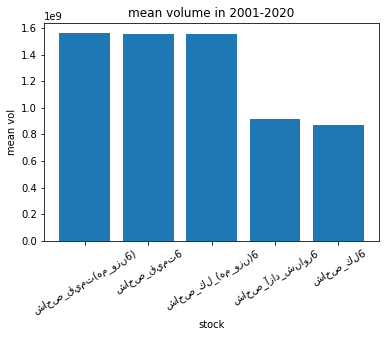

In [14]:
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [26]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL,VAL,NUM_OF_TRANSACTIONS,CLOSE_ONE_DAY_BEFORE,LABEL
3004878,شاخص_قيمت(هم_وزن6),20150224,9198.4,9181.8,9181.8,9181.8,278521094,6.199195e+11,31899,592.6,0
3004879,شاخص_قيمت(هم_وزن6),20150225,9183.3,9109.1,9109.2,9109.1,271188153,5.908300e+11,28391,21957.9,0
3004880,شاخص_قيمت(هم_وزن6),20150228,9111.9,9090.0,9090.0,9090.0,257849083,4.914391e+11,23864,590.0,0
3004881,شاخص_قيمت(هم_وزن6),20150301,9014.4,9030.4,9009.0,9030.4,475683577,1.030119e+12,37612,21635.1,0
3004882,شاخص_قيمت(هم_وزن6),20150302,9034.4,9043.5,9034.4,9043.5,717632564,9.735307e+11,39724,588.2,1


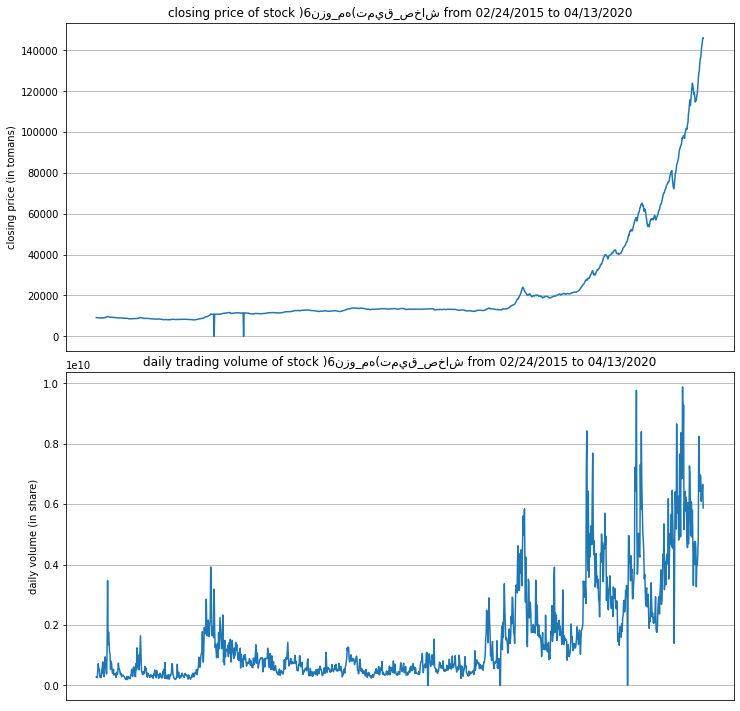

In [16]:
from datetime import datetime

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
fig.tight_layout()

ax1 = axs[0]
ax2 = axs[1]
starting_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[0])
ending_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[len(data_for_ticker_with_max_mean_vol) - 1])
starting_date_object = datetime.strptime(starting_date,'%Y%m%d')
ending_date_object = datetime.strptime(ending_date,'%Y%m%d')
starting_date_in_new_format = starting_date_object.strftime('%m/%d/%Y')
ending_date_in_new_format = ending_date_object.strftime('%m/%d/%Y')

ax1.plot(data_for_ticker_with_max_mean_vol['CLOSE'])
ax1.set(ylabel='closing price (in tomans)')
ax1.set_title('closing price of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date_in_new_format + ' to ' + ending_date_in_new_format)
# ax1.xticks([], labels=" ")
ax2.plot(data_for_ticker_with_max_mean_vol['VOL'])
ax2.set(ylabel='daily volume (in share)')
ax2.set_title('daily trading volume of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date_in_new_format + ' to ' + ending_date_in_new_format)
plt.xticks([], labels="")
ax1.grid(True)
ax2.grid(True)
plt.show()

In [0]:
ten_stocks_with_max_trading_per_day = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_per_day = ten_stocks_with_max_trading_per_day['TICKER'].iloc[0]

In [29]:
data_related_to_max_trading_stock = data[ data['TICKER' ] == stock_with_max_trading_per_day ]
data_related_to_max_trading_stock = data_related_to_max_trading_stock.drop(['TICKER', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'],1)
data_related_to_max_trading_stock

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,LABEL
729611,20010325,2140.0,2140.0,2139.0,2140.0,163488,1
729612,20010326,2135.0,2100.0,2100.0,2100.0,17577,0
729613,20010327,2100.0,2050.0,2045.0,2050.0,97608,0
729614,20010328,2049.0,2100.0,2020.0,2100.0,59019,1
729615,20010331,2101.0,2205.0,2100.0,2205.0,85296,1
...,...,...,...,...,...,...,...
733972,20200407,13537.0,13538.0,12665.0,13398.0,6530898,1
733973,20200408,13850.0,14067.0,13615.0,13989.0,9576755,1
733974,20200411,14490.0,14688.0,13463.0,14479.0,7285102,1
733975,20200412,15087.0,15029.0,14971.0,14699.0,1243068,1
